In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/232436.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/9223372032559845577.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/9223372032559864582.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/232432.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/232422.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/340319.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/295680.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/232433.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/9223372032559845895.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/278467.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/278662.jpg
/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/232574.jpg
/kaggle/input

In [3]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50,InceptionV3,DenseNet121,Xception,EfficientNetB1
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import Precision,Recall,F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing import image
import os
from glob import glob
import shutil
import random
from shutil import copyfile

In [4]:
import os

categories = [
    "Academic_Art", "Art_Nouveau", "Baroque", "Expressionism",
    "Japanese_Art", "Neoclassicism", "Primitivism", "Realism",
    "Renaissance", "Rococo", "Romanticism", "Symbolism", "Western_Medieval"
]

base_dir = '/kaggle/working/art_styles'
sub_dirs = ['train', 'validate', 'test']

try:
    # Create main directories
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    
    for sub_dir in sub_dirs:
        dir_path = os.path.join(base_dir, sub_dir)
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        
        # Create subdirectories for each category
        for category in categories:
            category_dir = os.path.join(dir_path, category)
            if not os.path.exists(category_dir):
                os.mkdir(category_dir)
                
    print("Directories created successfully.")
except OSError as e:
    print(f"Error: {e}")


Directories created successfully.


In [5]:
Academic_Art_DIR = '/kaggle/input/wikiart-art-movementsstyles/Academic_Art/Academic_Art/'
Art_Nouveau_DIR = '/kaggle/input/wikiart-art-movementsstyles/Art_Nouveau/Art_Nouveau/'
Baroque_DIR = '/kaggle/input/wikiart-art-movementsstyles/Baroque/Baroque/'
Expressionism_DIR = '/kaggle/input/wikiart-art-movementsstyles/Expressionism/Expressionism/'
Japanese_Art_DIR = '/kaggle/input/wikiart-art-movementsstyles/Japanese_Art/Japanese_Art/'
Neoclassicism_DIR = '/kaggle/input/wikiart-art-movementsstyles/Neoclassicism/Neoclassicism/'
Primitivism_DIR = '/kaggle/input/wikiart-art-movementsstyles/Primitivism/Primitivism/'
Realism_DIR = '/kaggle/input/wikiart-art-movementsstyles/Realism/Realism/'
Renaissance_DIR = '/kaggle/input/wikiart-art-movementsstyles/Renaissance/Renaissance/'
Rococo_DIR = '/kaggle/input/wikiart-art-movementsstyles/Rococo/Rococo/'
Romanticism_DIR = '/kaggle/input/wikiart-art-movementsstyles/Romanticism/Romanticism/'
Symbolism_DIR = '/kaggle/input/wikiart-art-movementsstyles/Symbolism/Symbolism/'
Western_Medieval_DIR = '/kaggle/input/wikiart-art-movementsstyles/Western_Medieval/Western_Medieval/'
Art_Nouveau_Modern_DIR = '/kaggle/input/wikiart-art-movementsstyles/Art_Nouveau_Modern/Art_Nouveau_Modern/'
Cubism_DIR = '/kaggle/input/wikiart-art-movementsstyles/Cubism/Cubism/'

print("Successful directory creation")

Successful directory creation


Test, Train, Split Data Custom Function

In [6]:
import os
import shutil 
from sklearn.model_selection import train_test_split
import logging

# Logs and handles messages with a severity level of INFO and higher
# Inserts the time, severity, and message of the log
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def split_data(main_dir, training_dir, validation_dir, test_dir, split_size, max_files=700, random_seed=24):
    """ Splits data into training, validation, and test sets and copies them to respective directories. """
    
    # Ensure that split_size and main_dir provided are valid
    if not main_dir or not os.path.exists(main_dir):
        logging.error("Error: main_dir is invalid or does not exist.")
        return

    if not (0 < split_size < 1):
        logging.error("Error: split_size must be between 0 and 1.")
        return

    # Ensure destination directories exist
    os.makedirs(training_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Retrieve all files from the main directory 
    all_files = [file for file in os.listdir(main_dir) if os.path.getsize(os.path.join(main_dir, file)) > 0]

    if not all_files:
        logging.error("Error: main directory is empty.")
        return 

    # Limit the total number of files to max_files if there are more
    if len(all_files) > max_files:
        all_files = all_files[:max_files]
        logging.info(f"Limiting to {max_files} files out of {len(all_files)} total.")

    # Split the data into training, validation, and test sets
    train_files, remaining_files = train_test_split(all_files, train_size=split_size, random_state=random_seed)
    validation_files, test_files = train_test_split(remaining_files, test_size=0.5, random_state=random_seed)

    # Copy files to their respective directories
    copy_files(main_dir, training_dir, train_files)
    copy_files(main_dir, validation_dir, validation_files)
    copy_files(main_dir, test_dir, test_files)

    logging.info("Split successful!")
    print("Split successful!")


def copy_files(source_dir, destination_dir, file_list):
    """ Copies files from the source directory to the destination directory. """
    for file in file_list:
        try:
            source_path = os.path.join(source_dir, file)
            destination_path = os.path.join(destination_dir, file)
            shutil.copyfile(source_path, destination_path)
            logging.info(f"Copied {file} to {destination_path}")
        except Exception as e:
            logging.error(f"Error copying {file}: {e}")


In [7]:
'''# List of categories
categories = [
    "Academic_Art", "Art_Nouveau", "Baroque", "Expressionism",
    "Japanese_Art", "Neoclassicism", "Primitivism", "Realism",
    "Renaissance", "Rococo", "Romanticism", "Symbolism", "Western_Medieval"
]

# Base directories
base_dir = '/kaggle/working/art_styles'
split_size = 0.8

# Loop through each category and split the data
for category in categories:
    main_directory = os.path.join(base_dir, category)
    train_directory = os.path.join(base_dir, 'train', category)
    validation_directory = os.path.join(base_dir, 'validate', category)
    test_directory = os.path.join(base_dir, 'test', category)

    split_data(main_directory, train_directory, validation_directory, test_directory, split_size)'''

'# List of categories\ncategories = [\n    "Academic_Art", "Art_Nouveau", "Baroque", "Expressionism",\n    "Japanese_Art", "Neoclassicism", "Primitivism", "Realism",\n    "Renaissance", "Rococo", "Romanticism", "Symbolism", "Western_Medieval"\n]\n\n# Base directories\nbase_dir = \'/kaggle/working/art_styles\'\nsplit_size = 0.8\n\n# Loop through each category and split the data\nfor category in categories:\n    main_directory = os.path.join(base_dir, category)\n    train_directory = os.path.join(base_dir, \'train\', category)\n    validation_directory = os.path.join(base_dir, \'validate\', category)\n    test_directory = os.path.join(base_dir, \'test\', category)\n\n    split_data(main_directory, train_directory, validation_directory, test_directory, split_size)'

In [8]:
# Base directories
base_dir = '/kaggle/working/art_styles'
split_size = 0.8

# Split data for each category individually
split_data(Academic_Art_DIR, "/kaggle/working/art_styles/train/Academic_Art", "/kaggle/working/art_styles/validate/Academic_Art", "/kaggle/working/art_styles/test/Academic_Art", split_size)
split_data(Art_Nouveau_DIR, "/kaggle/working/art_styles/train/Art_Nouveau", "/kaggle/working/art_styles/validate/Art_Nouveau", "/kaggle/working/art_styles/test/Art_Nouveau", split_size)
split_data(Baroque_DIR, "/kaggle/working/art_styles/train/Baroque", "/kaggle/working/art_styles/validate/Baroque", "/kaggle/working/art_styles/test/Baroque", split_size)
split_data(Expressionism_DIR, "/kaggle/working/art_styles/train/Expressionism", "/kaggle/working/art_styles/validate/Expressionism", "/kaggle/working/art_styles/test/Expressionism", split_size)
split_data(Japanese_Art_DIR, "/kaggle/working/art_styles/train/Japanese_Art", "/kaggle/working/art_styles/validate/Japanese_Art", "/kaggle/working/art_styles/test/Japanese_Art", split_size)
split_data(Neoclassicism_DIR, "/kaggle/working/art_styles/train/Neoclassicism", "/kaggle/working/art_styles/validate/Neoclassicism", "/kaggle/working/art_styles/test/Neoclassicism", split_size)
split_data(Primitivism_DIR, "/kaggle/working/art_styles/train/Primitivism", "/kaggle/working/art_styles/validate/Primitivism", "/kaggle/working/art_styles/test/Primitivism", split_size)
split_data(Realism_DIR, "/kaggle/working/art_styles/train/Realism", "/kaggle/working/art_styles/validate/Realism", "/kaggle/working/art_styles/test/Realism", split_size)
split_data(Renaissance_DIR, "/kaggle/working/art_styles/train/Renaissance", "/kaggle/working/art_styles/validate/Renaissance", "/kaggle/working/art_styles/test/Renaissance", split_size)
split_data(Rococo_DIR, "/kaggle/working/art_styles/train/Rococo", "/kaggle/working/art_styles/validate/Rococo", "/kaggle/working/art_styles/test/Rococo", split_size)
split_data(Romanticism_DIR, "/kaggle/working/art_styles/train/Romanticism", "/kaggle/working/art_styles/validate/Romanticism", "/kaggle/working/art_styles/test/Romanticism", split_size)
split_data(Symbolism_DIR, "/kaggle/working/art_styles/train/Symbolism", "/kaggle/working/art_styles/validate/Symbolism", "/kaggle/working/art_styles/test/Symbolism", split_size)
split_data(Western_Medieval_DIR, "/kaggle/working/art_styles/train/Western_Medieval", "/kaggle/working/art_styles/validate/Western_Medieval", "/kaggle/working/art_styles/test/Western_Medieval", split_size)
split_data(Art_Nouveau_Modern_DIR, "/kaggle/working/art_styles/train/Art_Nouveau_Modern", "/kaggle/working/art_styles/validate/Art_Nouveau_Modern", "/kaggle/working/art_styles/test/Art_Nouveau_Modern", split_size)
split_data(Cubism_DIR, "/kaggle/working/art_styles/train/Cubism", "/kaggle/working/art_styles/validate/Cubism", "/kaggle/working/art_styles/test/Cubism", split_size)

Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!


Image Preprocessing/Data Augmentation/Rescaling

In [9]:
#Categorical/Class Model for Multi-class classification 
#Batch processing/Data Pipelining implementation 

train_gen = ImageDataGenerator(
        rescale=1./255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest'                
                   )


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

test_gen =  ImageDataGenerator(
            rescale=1./255.)
train_generator = train_gen.flow_from_directory(
        '/kaggle/working/art_styles/train',
        target_size=(256, 256),
        batch_size=64,
        class_mode="categorical")
validation_generator = validation_gen.flow_from_directory(
        '/kaggle/working/art_styles/validate',
        target_size=(256, 256),
        batch_size=64,
        class_mode="categorical")

test_generator = test_gen.flow_from_directory(
        '/kaggle/working/art_styles/test',
        target_size=(256, 256),
        batch_size=64,
        shuffle= False,
        class_mode="categorical")

Found 7280 images belonging to 13 classes.
Found 910 images belonging to 13 classes.
Found 910 images belonging to 13 classes.


Model Architecture, Compile, Fit Implementing Transfer Learning 

In [10]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Adding input layer
input_layer = Input(shape=(256, 256, 3))

# Base model with Xception
base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_layer)
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    Input(shape=(256, 256, 3)),
    (base_model),
    (GlobalAveragePooling2D()),
    (Dense(1024, activation='relu', kernel_regularizer=l2(0.001))),
    (BatchNormalization()),
    (Dropout(0.2)),
    (Dense(len(categories), activation='linear')) 
])

# Using from_logits=True in the loss function to reduce nuemrical roundoff error
loss_fn = CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=Adam(), loss=loss_fn, metrics=['accuracy'])
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 8, 8, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │          13,325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,977,077 (87.65 MB)

 Trainable params: 2,113,549 (8.06 MB)

 Non-trainable params: 20,863,528 (79.59 MB)

In [11]:
# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [15]:
result = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 598s 19s/step - accuracy: 0.5584 - loss: 2.6857 - val_accuracy: 0.4451 - val_loss: 2.9909 - learning_rate: 0.0010
Epoch 2/10
17/30 ━━━━━━━━━━━━━━━━━━━━ 3:16 15s/step - accuracy: 0.5715 - loss: 2.6797Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-b3584f0e8d1d>", line 1, in <cell line: 1>
    result = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/d

TypeError: object of type 'NoneType' has no len()

In [16]:
import tensorflow as tf

save_path = "/kaggle/working/art_styles/model.h5"  
model.save(save_path)
print("Model successfully saved")

Model successfully saved


Analyze Fine-Tuned Model's Attributes (Loss, Accuracy, Confusion Matrix, Sample Predictions)

Found 910 images belonging to 13 classes.
15/15 ━━━━━━━━━━━━━━━━━━━━ 176s 12s/step - accuracy: 0.5149 - loss: 2.7181
Accuracy:
 0.45604395866394043
Loss:
 2.9093539714813232
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


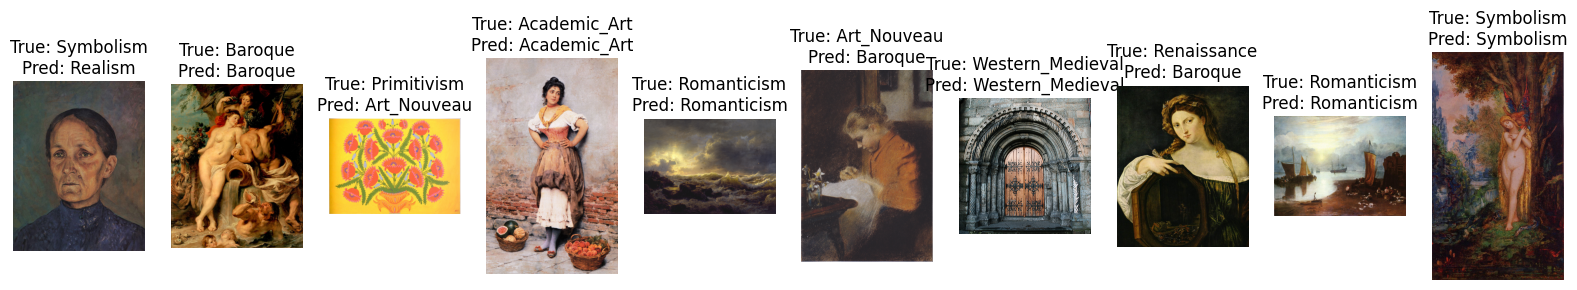

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
# Generate validation generator
validation_generator = validation_gen.flow_from_directory(
    '/kaggle/working/art_styles/validate',
    target_size=(256, 256),
    batch_size=64,
    shuffle=False,
    class_mode="categorical"
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Accuracy:\n", accuracy)
print("Loss:\n", loss)

class_labels = [
    "Academic_Art", "Art_Nouveau", "Baroque", "Expressionism",
    "Japanese_Art", "Neoclassicism", "Primitivism", "Realism",
    "Renaissance", "Rococo", "Romanticism", "Symbolism", "Western_Medieval"
]

# Display 10 random images with their true and predicted labels
def display_random_images(generator, model, class_labels, num_images=10):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        index = random.randint(0, len(generator.filepaths) - 1)
        img_path = generator.filepaths[index]
        img = Image.open(img_path)
        img_resized = img.resize((256, 256))
        
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_label = class_labels[predicted_class]
        
        true_class = generator.classes[index]
        true_label = class_labels[true_class]
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    plt.show()

# Call the function to display images
display_random_images(validation_generator, model, class_labels, num_images=10)
